# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_20', 'ORACLE.run2_38', 'ORACLE.run2_44', 'ORACLE.run2_32', 'ORACLE.run2_14', 'ORACLE.run2_50', 'ORACLE.run2_8', 'ORACLE.run2_26'}


{'ORACLE.run1_32', 'ORACLE.run1_38', 'ORACLE.run1_8', 'ORACLE.run1_44', 'ORACLE.run1_26', 'ORACLE.run1_20', 'ORACLE.run1_14', 'ORACLE.run1_50'}


tensor([[[ 0.4547, -1.1971,  0.0000,  ...,  1.2157, -0.0835, -0.1670],
         [ 0.6589, -0.0557, -0.7424,  ..., -0.1578,  1.1600,  0.8816]],

        [[-1.0285,  0.0649,  1.3065,  ..., -0.4355, -0.8432,  0.9173],
         [-0.3150, -0.6301,  0.4911,  ...,  1.1212,  0.7598,  0.8340]],

        [[-1.0597, -0.4834,  1.0039,  ...,  0.5670,  0.2231,  1.1062],
         [ 0.6321, -0.7158, -0.7622,  ...,  1.2456,  0.8087, -0.1394]],

        ...,

        [[-0.6325,  0.4285,  0.6869,  ..., -0.1156, -1.1289, -0.9249],
         [ 0.0612, -1.0813,  0.4353,  ...,  1.1425, -0.5577, -0.2788]],

        [[ 0.2676, -1.1046,  0.0617,  ...,  1.0840,  0.3911,  0.7135],
         [ 0.6243,  0.4528, -0.9742,  ..., -0.5008,  1.2829,  0.5214]],

        [[-0.2927, -0.7964,  0.1702,  ...,  1.1299,  0.8509,  0.7351],
         [ 1.1912, -0.0272, -1.3273,  ...,  0.2655,  0.5037, -1.0755]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.9590, train_label_loss: 2.7966, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3342.8526, train_label_loss: 0.7590, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3544.9575, train_label_loss: 0.6094, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3677.6178, train_label_loss: 1.3835, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3944.9836, train_label_loss: 0.4143, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3522.0171, train_label_loss: 0.5004, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3460.0730, train_label_loss: 0.8041, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3439.0452, train_label_loss: 0.4506, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3381.1450, train_label_loss: 0.7508, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3400.9105, train_label_loss: 0.3839, 


epoch: 1, source_val_acc_label: 0.7922, target_val_acc_label: 0.8024, source_val_label_loss: 8.0260, target_val_label_loss: 4.7139, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.2858, train_label_loss: 0.6297, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2576.2881, train_label_loss: 0.6695, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2551.2907, train_label_loss: 0.6357, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2736.9333, train_label_loss: 0.3928, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2987.8696, train_label_loss: 0.6231, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3005.9116, train_label_loss: 0.3481, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3082.6287, train_label_loss: 0.6921, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3437.2226, train_label_loss: 0.4707, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3488.2205, train_label_loss: 0.3521, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3187.1334, train_label_loss: 0.7340, 


epoch: 2, source_val_acc_label: 0.8116, target_val_acc_label: 0.8168, source_val_label_loss: 0.5351, target_val_label_loss: 0.5065, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7608, train_label_loss: 0.2940, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2286.3531, train_label_loss: 0.6291, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2312.5722, train_label_loss: 0.8885, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2297.9045, train_label_loss: 0.4004, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2285.0276, train_label_loss: 0.4512, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2297.9885, train_label_loss: 0.3239, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2544.7818, train_label_loss: 0.3742, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2575.9958, train_label_loss: 0.4031, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2600.7848, train_label_loss: 0.3810, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2306.7295, train_label_loss: 0.3512, 


epoch: 3, source_val_acc_label: 0.8359, target_val_acc_label: 0.8414, source_val_label_loss: 0.4597, target_val_label_loss: 0.4427, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.2416, train_label_loss: 0.4805, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2283.5052, train_label_loss: 0.6601, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2314.8054, train_label_loss: 0.5248, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2314.1663, train_label_loss: 0.2318, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2328.8163, train_label_loss: 0.7532, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2475.8736, train_label_loss: 0.7437, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2617.4984, train_label_loss: 0.2585, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2648.0248, train_label_loss: 0.3725, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2363.3985, train_label_loss: 0.1210, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2318.7107, train_label_loss: 0.2616, 


epoch: 4, source_val_acc_label: 0.8648, target_val_acc_label: 0.8570, source_val_label_loss: 0.3793, target_val_label_loss: 0.3947, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.2428, train_label_loss: 0.1421, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2296.3068, train_label_loss: 0.7202, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2320.0690, train_label_loss: 0.2568, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2297.0274, train_label_loss: 0.4721, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2502.3608, train_label_loss: 0.6361, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2983.2663, train_label_loss: 0.0578, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2944.3673, train_label_loss: 0.2448, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2866.7205, train_label_loss: 0.4781, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2586.4391, train_label_loss: 0.2427, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2621.7053, train_label_loss: 0.0475, 


epoch: 5, source_val_acc_label: 0.8753, target_val_acc_label: 0.8731, source_val_label_loss: 0.3427, target_val_label_loss: 0.3575, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.7947, train_label_loss: 1.4285, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2334.4990, train_label_loss: 0.3474, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2307.4146, train_label_loss: 0.1202, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2308.6511, train_label_loss: 0.5208, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2487.4394, train_label_loss: 0.0392, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2616.6507, train_label_loss: 0.2411, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2653.8841, train_label_loss: 0.2192, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2332.3474, train_label_loss: 0.3105, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2328.5961, train_label_loss: 0.8812, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2331.4001, train_label_loss: 0.3908, 


epoch: 6, source_val_acc_label: 0.8821, target_val_acc_label: 0.8743, source_val_label_loss: 0.3307, target_val_label_loss: 0.3625, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.2245, train_label_loss: 0.5491, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2296.5269, train_label_loss: 0.5990, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2312.7170, train_label_loss: 0.4879, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2413.9746, train_label_loss: 0.0635, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2549.8571, train_label_loss: 0.5998, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2662.4698, train_label_loss: 0.1587, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2338.3740, train_label_loss: 0.1404, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2293.1285, train_label_loss: 0.4437, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2315.1922, train_label_loss: 0.4394, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2292.8667, train_label_loss: 0.2251, 


epoch: 7, source_val_acc_label: 0.8892, target_val_acc_label: 0.8798, source_val_label_loss: 0.3047, target_val_label_loss: 0.3434, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.2494, train_label_loss: 0.0453, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2300.8006, train_label_loss: 0.2331, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2420.5161, train_label_loss: 0.0943, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2615.1202, train_label_loss: 0.2848, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2592.7534, train_label_loss: 0.0788, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2494.1511, train_label_loss: 0.2263, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2312.7009, train_label_loss: 0.2372, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2327.1097, train_label_loss: 0.1769, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2324.5297, train_label_loss: 0.0782, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2307.8456, train_label_loss: 0.0873, 


epoch: 8, source_val_acc_label: 0.8889, target_val_acc_label: 0.8747, source_val_label_loss: 0.3064, target_val_label_loss: 0.3582, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.2264, train_label_loss: 0.5891, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2571.3945, train_label_loss: 0.1130, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2923.4288, train_label_loss: 0.2796, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2925.0327, train_label_loss: 0.3278, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2937.1878, train_label_loss: 0.4311, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2655.5918, train_label_loss: 0.6952, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2622.5115, train_label_loss: 0.2133, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2584.0559, train_label_loss: 0.1164, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2611.1197, train_label_loss: 0.3295, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2638.0429, train_label_loss: 0.1013, 


epoch: 9, source_val_acc_label: 0.8920, target_val_acc_label: 0.8774, source_val_label_loss: 0.2986, target_val_label_loss: 0.3531, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.8423, train_label_loss: 0.2070, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3465.2863, train_label_loss: 0.4597, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3685.5686, train_label_loss: 0.1321, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3654.8901, train_label_loss: 0.2206, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3773.4480, train_label_loss: 0.2064, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3372.2456, train_label_loss: 0.2108, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3233.5469, train_label_loss: 0.0355, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3237.2555, train_label_loss: 0.1420, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2548.3425, train_label_loss: 0.2223, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2560.5826, train_label_loss: 0.0490, 


epoch: 10, source_val_acc_label: 0.8926, target_val_acc_label: 0.8757, source_val_label_loss: 0.2923, target_val_label_loss: 0.3520, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.4468, train_label_loss: 0.1010, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2878.0470, train_label_loss: 0.1426, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3016.6662, train_label_loss: 0.1044, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3376.3838, train_label_loss: 0.1694, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3402.2652, train_label_loss: 0.4148, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3266.3414, train_label_loss: 0.6252, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3012.3204, train_label_loss: 0.1816, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2975.6434, train_label_loss: 0.4278, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2896.3936, train_label_loss: 0.2222, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2328.9185, train_label_loss: 0.2719, 


epoch: 11, source_val_acc_label: 0.9023, target_val_acc_label: 0.8875, source_val_label_loss: 0.2758, target_val_label_loss: 0.3276, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.0104, train_label_loss: 0.2984, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2297.3903, train_label_loss: 0.1398, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2421.8910, train_label_loss: 0.0844, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2595.1392, train_label_loss: 0.1988, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2537.6793, train_label_loss: 0.0927, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2638.9316, train_label_loss: 0.2757, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2611.3026, train_label_loss: 0.3792, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2644.4675, train_label_loss: 0.1382, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2511.2518, train_label_loss: 0.1188, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2325.3924, train_label_loss: 0.4737, 


epoch: 12, source_val_acc_label: 0.8942, target_val_acc_label: 0.8772, source_val_label_loss: 0.2916, target_val_label_loss: 0.3549, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.0019, train_label_loss: 0.0726, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2313.1178, train_label_loss: 0.1745, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2431.4039, train_label_loss: 0.0856, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2635.8627, train_label_loss: 0.1059, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2629.9989, train_label_loss: 0.2090, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2920.7012, train_label_loss: 0.2298, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2620.4888, train_label_loss: 0.1545, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2585.7726, train_label_loss: 0.0659, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2308.9099, train_label_loss: 0.2545, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2315.5706, train_label_loss: 0.3647, 


epoch: 13, source_val_acc_label: 0.8996, target_val_acc_label: 0.8810, source_val_label_loss: 0.2877, target_val_label_loss: 0.3533, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.0193, train_label_loss: 0.1734, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2315.3173, train_label_loss: 0.0859, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2369.1494, train_label_loss: 0.3035, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2567.5077, train_label_loss: 0.1175, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2856.0586, train_label_loss: 0.0409, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2872.1037, train_label_loss: 0.4887, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2617.3475, train_label_loss: 0.1220, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2527.8650, train_label_loss: 0.1078, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2563.1683, train_label_loss: 0.1654, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2586.7391, train_label_loss: 0.0235, 


epoch: 14, source_val_acc_label: 0.9006, target_val_acc_label: 0.8839, source_val_label_loss: 0.2810, target_val_label_loss: 0.3525, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.3207, train_label_loss: 0.0296, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2683.9966, train_label_loss: 0.1930, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3140.0336, train_label_loss: 0.1113, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2750.0597, train_label_loss: 0.1521, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2965.5792, train_label_loss: 0.3206, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2999.8010, train_label_loss: 0.0720, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2605.9714, train_label_loss: 0.1467, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2602.9526, train_label_loss: 0.1915, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2588.9206, train_label_loss: 0.1208, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2595.2421, train_label_loss: 0.2198, 


epoch: 15, source_val_acc_label: 0.9019, target_val_acc_label: 0.8816, source_val_label_loss: 0.2829, target_val_label_loss: 0.3532, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

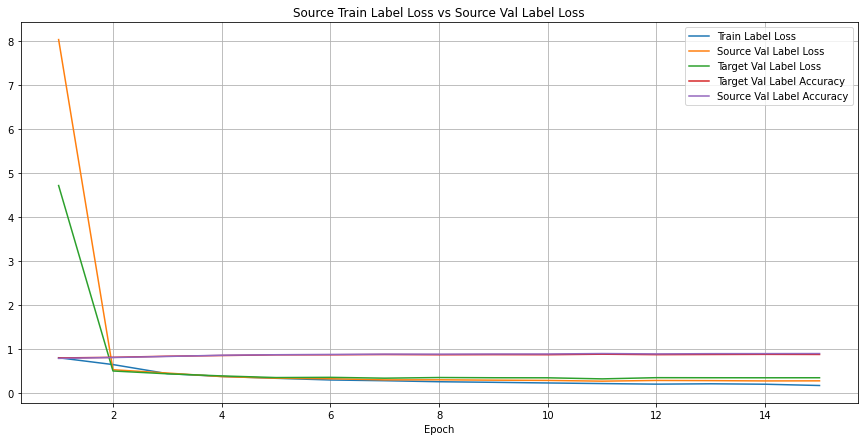

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

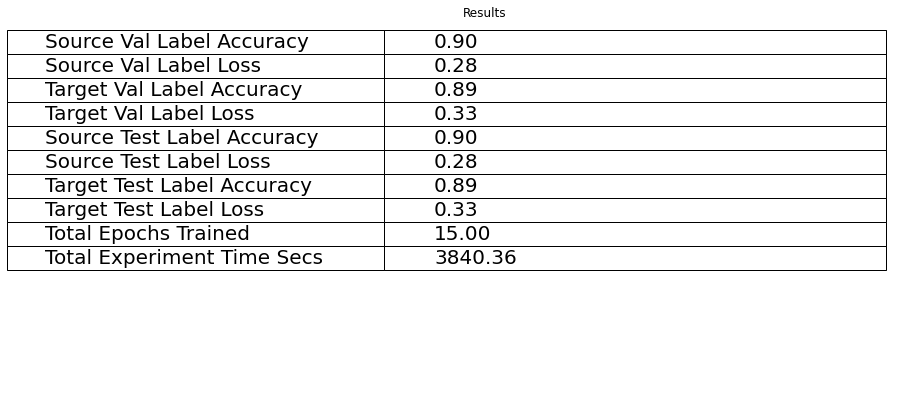

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

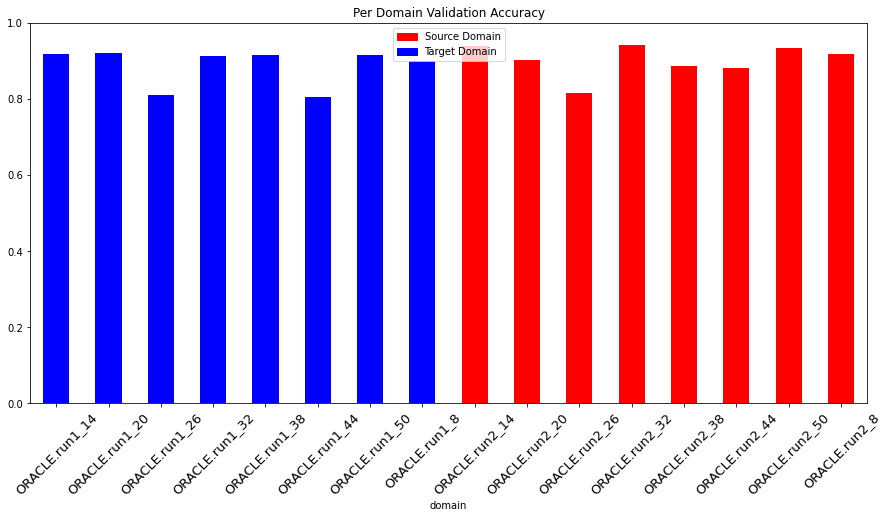

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.89853515625 Target Test Label Accuracy: 0.8871419270833333
Source Val Label Accuracy: 0.9022786458333333 Target Val Label Accuracy: 0.8874674479166667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048